<a href="https://colab.research.google.com/github/sumaiyaSultanaTarin/CVPR_23_24_Spring/blob/main/FedAvg_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


# FedAvg






In [ ]:
!git clone https://github.com/Chelsiehi/FedAvg-Algorithm

Cloning into 'FedAvg-Algorithm'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 68 (delta 2), reused 64 (delta 1), pack-reused 0
Receiving objects: 100% (68/68), 328.72 KiB | 2.03 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [ ]:
%cd FedAvg-Algorithm

/content/FedAvg-Algorithm


In [ ]:
%cd FedAvg-Algorithm/.idea

[Errno 2] No such file or directory: 'FedAvg-Algorithm/.idea'
/content/FedAvg-Algorithm


In [ ]:

%cd FedAvg-Algorithm/log


[Errno 2] No such file or directory: 'FedAvg-Algorithm/log'
/content/FedAvg-Algorithm


In [ ]:
!ls

log  main.py  models  README.md  run.md  utils


In [ ]:
%cd FedAvg-Algorithm/log
%cd FedAvg-Algorithm/main.py
%cd FedAvg-Algorithm/models
%cd FedAvg-Algorithm/run.md
%cd FedAvg-Algorithm/utils

[Errno 2] No such file or directory: 'FedAvg-Algorithm/log'
/content/FedAvg-Algorithm
[Errno 2] No such file or directory: 'FedAvg-Algorithm/main.py'
/content/FedAvg-Algorithm
[Errno 2] No such file or directory: 'FedAvg-Algorithm/models'
/content/FedAvg-Algorithm
[Errno 2] No such file or directory: 'FedAvg-Algorithm/run.md'
/content/FedAvg-Algorithm
[Errno 2] No such file or directory: 'FedAvg-Algorithm/utils'
/content/FedAvg-Algorithm


In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# @python: 3.6


**Clientt**

In [ ]:
from torch import nn
import torch.nn.functional as F


class CNNMnist(nn.Module):
    def __init__(self, args):
        super(CNNMnist, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, args.num_classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x


class CNNCifar(nn.Module):
    def __init__(self, args):
        super(CNNCifar, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, args.num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

***Nets***

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset


class DatasetSplit(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = list(idxs)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, label

#local training

class Local(object):
    def __init__(self, args, dataset=None, idxs=None):
        self.args = args
        self.loss_func = nn.CrossEntropyLoss()
        self.selected_clients = []
        self.ldr_train = DataLoader(DatasetSplit(dataset, idxs), batch_size=self.args.local_bs, shuffle=True)
#Trained MODEL USING stochastic gradient descent
    def train(self, net):
        net.train()
        optimizer = torch.optim.SGD(net.parameters(), lr=self.args.lr, momentum=self.args.momentum)

        epoch_loss = []
        for iter_ in range(self.args.local_ep):
            batch_loss = []
            for batch_idx, (images, labels) in enumerate(self.ldr_train):
                images, labels = images.to(self.args.device), labels.to(self.args.device)
                net.zero_grad()
                log_probs = net(images)
                loss = self.loss_func(log_probs, labels)
                loss.backward()
                optimizer.step()

                batch_loss.append(loss.item())
            epoch_loss.append(sum(batch_loss)/len(batch_loss))
        return net.state_dict(), sum(epoch_loss) / len(epoch_loss)


**FedAvg**

In [ ]:
import copy
import torch


def FedAvg(w):
    w_avg = copy.deepcopy(w[0])
    for k in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[k] += w[i][k]
        w_avg[k] = torch.div(w_avg[k], len(w))
    return w_avg

**Data**

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15979202.31it/s]


Extracting ../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 483488.77it/s]


Extracting ../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4377149.22it/s]


Extracting ../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4288727.77it/s]


Extracting ../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw



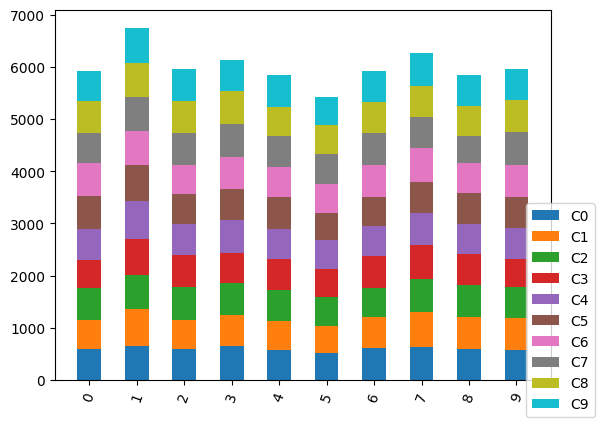

100%|██████████| 170498071/170498071 [00:03<00:00, 48930805.75it/s]


Extracting ../data/cifar/cifar-10-python.tar.gz to ../data/cifar/


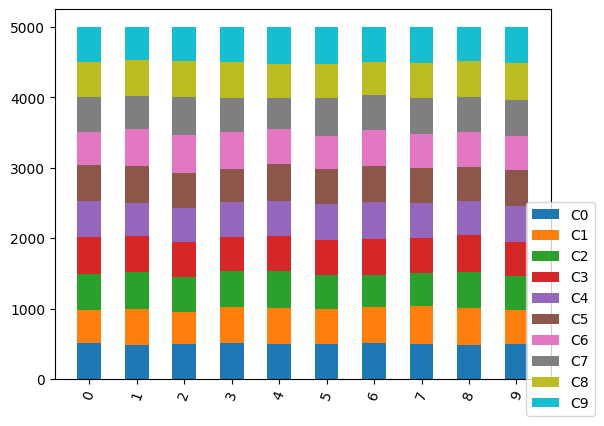

In [ ]:
import os.path

import numpy as np
from torchvision import datasets, transforms

#IID data Prtitioning
def build_iid_data(dataset, num_users):
    num_items = int(len(dataset)/num_users)
    dict_users, all_idxs = {}, [i for i in range(len(dataset))]
    for i in range(num_users):
        user_items = set(np.random.choice(all_idxs, num_items, replace=False))
        all_idxs = list(set(all_idxs) - user_items)
        dict_users[i] = list(user_items)
    return dict_users

#Non-IID Partitioning
def build_noniid_data(dataset, num_users):
    num_shards, num_imgs = 2 * num_users, len(dataset.targets) // (2 * num_users)
    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([], dtype='int64') for i in range(num_users)}
    idxs = np.arange(num_shards * num_imgs)
    labels = dataset.targets.numpy()

    # sort labels
    idxs_labels = np.vstack((idxs, labels))
    idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
    idxs = idxs_labels[0, :]

    # divide and assign
    for i in range(num_users):
        rand_set = set(np.random.choice(idx_shard, 2, replace=False))
        idx_shard = list(set(idx_shard) - rand_set)
        for rand in rand_set:
            dict_users[i] = np.concatenate((dict_users[i], idxs[rand * num_imgs:(rand + 1) * num_imgs]), axis=0)
    return dict_users


def build_dir_data(dataset, num_users, alpha):
    train_labels = np.array(dataset.targets, dtype='int64')
    n_classes = np.max(train_labels) + 1
    # Dirichlet distribution
    label_distribution = np.random.dirichlet([alpha] * num_users, n_classes)
    # (K, N) category label distribution matrix X, recording how much each client occupies each category

    class_idxs = [np.argwhere(train_labels == y).flatten()
                  for y in range(n_classes)]
    # Record the sample subscript corresponding to each K category

    client_idxs = [[] for _ in range(num_users)]
    # Record the indexes of N clients corresponding to the sample collection
    for c, fracs in zip(class_idxs, label_distribution):
        # np.split divides the samples of category k into N subsets according to the proportion
        # for i, idxs is the index of traversing the sample set corresponding to the i-th client
        for i, idxs in enumerate(np.split(c, (np.cumsum(fracs)[:-1] * len(c)).astype(int))):
            client_idxs[i] += [idxs]

    client_idxs = [np.concatenate(idxs) for idxs in client_idxs]

    dict_users = {}
    for i in range(len(client_idxs)):
        dict_users[i] = client_idxs[i]
    return dict_users


def draw_data_distribution(dict_users, dataset, num_class, fig_path="./"):
    import matplotlib.pyplot as plt
    targets = dataset.targets
    # plt.figure(figsize=(20, 3))

    plt.hist([np.array(targets)[list(idc)] for idc in dict_users.values()], stacked=True,
             bins=np.arange(min(targets) - 0.5, max(targets) + 1.5, 1),
             label=["C{}".format(i) for i in range(len(dict_users))], rwidth=0.5)
    plt.xticks(np.arange(num_class), rotation=70)
    plt.legend(loc=(0.95, -0.1))
    plt.savefig(os.path.join(fig_path, "data_distribution.jpg"))
    plt.show()


if __name__ == '__main__':
    dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True,
                                   transform=transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                   ]))
    num = 10
    d = build_iid_data(dataset_train, num)
    draw_data_distribution(d, dataset_train, 10)

    dataset_train = datasets.CIFAR10('../data/cifar/', train=True, download=True,
                                   transform=transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                   ]))
    num = 10
    d = build_iid_data(dataset_train, num)
    draw_data_distribution(d, dataset_train, 10)

In [ ]:
import sys
sys.path.append('/content/FedAvg-Algorithm/log')

**Options**

In [ ]:
import argparse


def args_parser():
    parser = argparse.ArgumentParser()
    # federated arguments
    parser.add_argument('--epochs', type=int, default=10, help="rounds of training")
    parser.add_argument('--num_users', type=int, default=10, help="number of users: K")
    parser.add_argument('--frac', type=float, default=0.3, help="the fraction of clients: C")
    parser.add_argument('--local_ep', type=int, default=5, help="the number of local epochs: E")
    parser.add_argument('--local_bs', type=int, default=10, help="local batch size: B")
    parser.add_argument('--bs', type=int, default=128, help="test batch size")
    parser.add_argument('--lr', type=float, default=0.01, help="learning rate")
    parser.add_argument('--momentum', type=float, default=0.5, help="SGD momentum (default: 0.5)")

    # model arguments
    parser.add_argument('--model', type=str, default='cnn', help='model name')

    # other arguments
    parser.add_argument('--dataset', type=str, default='mnist', help="name of dataset")
    parser.add_argument('--iid', action='store_true', help='whether i.i.d or not')
    parser.add_argument('--dir', action='store_true', help='whether dir-noniid or not')
    parser.add_argument('--dir_alpha', type=float, default=0.1, help='whether i.i.d or not')
    parser.add_argument('--num_classes', type=int, default=10, help="number of classes")
    parser.add_argument('--gpu', type=int, default=0, help="GPU ID, -1 for CPU")
    parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')
    args = parser.parse_args()
    return args

**Test**

In [ ]:
import torch.nn.functional as F
from torch.utils.data import DataLoader


def test_img(net_g, datatest, args):  #evaluate global model
    net_g.eval()
    test_loss = 0
    correct = 0
    data_loader = DataLoader(datatest, batch_size=args.bs)
    for idx, (data, target) in enumerate(data_loader):
        data, target = data.to(args.device), target.to(args.device)
        log_probs = net_g(data)
        # sum up batch loss
        test_loss += F.cross_entropy(log_probs, target, reduction='sum').item()
        # get the index of the max log-probability
        y_pred = log_probs.data.max(1, keepdim=True)[1]
        correct += y_pred.eq(target.data.view_as(y_pred)).long().cpu().sum()

    test_loss /= len(data_loader.dataset)
    accuracy = 100.00 * correct.item() / len(data_loader.dataset)
    return accuracy, test_loss


**Draw**

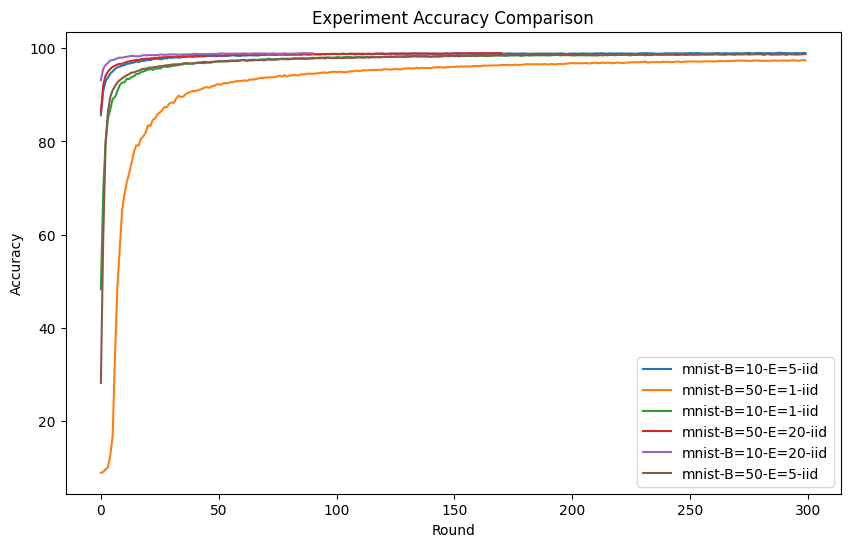

In [ ]:
import matplotlib.pyplot as plt
import os


def read_data(log_path):
    # Read experiment data for each experiment
    all_acc_list = []
    for exp in os.listdir(log_path):
        acc_list = read_exp_data(os.path.join(log_path, exp))
        all_acc_list.append((exp, acc_list))

    plt.figure(figsize=(10, 6))
    for exp, acc_list in all_acc_list:
        plt.plot(acc_list, label=exp)  # Plot the precision curve for each experiment

    plt.xlabel("Round")
    plt.ylabel("Accuracy")
    plt.title("Experiment Accuracy Comparison")
    plt.legend()
    plt.show()


def read_exp_data(exp_path):
    with open(os.path.join(exp_path, "accuracy.dat")) as f:
        acc_list = [float(i) for i in f.read().split()]
    return acc_list


if __name__ == '__main__':
    read_data("./log")

**Main**

In [ ]:
!pip install fedml
from models.Fed import FedAvg


import os.path

import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.data import build_iid_data, build_noniid_data, draw_data_distribution, build_dir_data
from utils.options import args_parser
from models.Client import Local
from models.Nets import CNNMnist, CNNCifar
from models.Fed import FedAvg
from utils.test import test_img

#Create Data Splits for each client
if __name__ == '__main__':
    args = args_parser()

    log_root = "./log"
    os.makedirs(log_root, exist_ok=True)
    log_path = os.path.join(log_root, f"{args.dataset}-B={args.local_bs}-E={args.local_ep}-{'iid' if args.iid else 'noniid'}")
    os.makedirs(log_path, exist_ok=True)
    args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

    if args.dataset == 'mnist':
        trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
        dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
        dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)
    elif args.dataset == 'cifar':
        trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        dataset_train = datasets.CIFAR10('../data/cifar', train=True, download=True, transform=trans_cifar)
        dataset_test = datasets.CIFAR10('../data/cifar', train=False, download=True, transform=trans_cifar)
    else:
        exit('Error: unrecognized dataset')

    if args.iid:
        dict_users = build_iid_data(dataset_train, args.num_users)
    else:
        if args.dir:
            dict_users = build_dir_data(dataset_train, args.num_users, args.dir_alpha)
        else:
            dict_users = build_noniid_data(dataset_train, args.num_users)

    draw_data_distribution(dict_users, dataset_train, args.num_classes, fig_path=log_path)

    # build model
    if args.model == 'cnn' and args.dataset == 'cifar':
        net_glob = CNNCifar(args=args).to(args.device)
    elif args.model == 'cnn' and args.dataset == 'mnist':
        net_glob = CNNMnist(args=args).to(args.device)
    else:
        exit('Error: unrecognized model')

    net_glob.train()

    # copy weights
    w_glob = net_glob.state_dict()
    w_glob = FedAvg(w_locals)

    # training
    loss_train = []
    acc_file = os.path.join(log_path, "accuracy.dat")
    acc_f = open(acc_file, "w", encoding="utf-8")

    loss_file = os.path.join(log_path, "loss.dat")
    loss_f = open(loss_file, "w", encoding="utf-8")

    client_loss_file = os.path.join(log_path, "client_avg_loss.dat")
    client_loss_f = open(client_loss_file, "w", encoding="utf-8")

    for iter_ in range(args.epochs):
        print(f"---Round {iter_}---")
        loss_locals = []
        w_locals = []
        m = max(int(args.frac * args.num_users), 1)
        idxs_users = np.random.choice(range(args.num_users), m, replace=False)
        for idx in idxs_users:
            local = Local(args=args, dataset=dataset_train, idxs=dict_users[idx])
            w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
            w_locals.append(copy.deepcopy(w))
            loss_locals.append(copy.deepcopy(loss))

        client_avg_loss = sum(loss_locals) / len(loss_locals)
        print(f"Client Train Avg Loss {client_avg_loss:.2f}")
        client_loss_f.write(str(client_avg_loss))
        client_loss_f.flush()

        # update global weights
        w_glob = FedAvg(w_locals)
        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)
        net_glob.eval()

        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        acc_f.write(str(acc_test) + "\n")
        acc_f.flush()
        loss_f.write(str(loss_test) + "\n")
        loss_f.flush()

        print("Global Testing accuracy: {:.2f}".format(acc_test))

  Using cached fedml-0.8.30-py2.py3-none-any.whl (1.2 MB)
  Using cached GPUtil-1.4.0.tar.gz (5.5 kB)
  Preparing metadata (setup.py) ... done
  Using cached attrdict-2.0.1-py2.py3-none-any.whl (9.9 kB)
  Using cached boto3-1.34.107-py3-none-any.whl (139 kB)
  Using cached dill-0.3.8-py3-none-any.whl (116 kB)
  Using cached docker-6.1.3-py3-none-any.whl (148 kB)
  Using cached fastapi-0.111.0-py3-none-any.whl (91 kB)
  Using cached geventhttpclient-2.0.9-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (103 kB)
  Using cached graphviz-0.8.4-py2.py3-none-any.whl (16 kB)
  Using cached httpx-0.27.0-py3-none-any.whl (75 kB)
  Using cached multiprocess-0.70.16-py310-none-any.whl (134 kB)
  Using cached networkx-2.8.8-py3-none-any.whl (2.0 MB)
  Using cached ntplib-0.4.0-py2.py3-none-any.whl (6.8 kB)
  Using cached onnx-1.16.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (15.9 MB)
  Using cached paho-mqtt-1.6.1.tar.gz (99 kB)
  